# Linear Module

In [52]:
import math
import torch
import torch.nn as nn
from einops import einsum

class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int, device=None, dtype=None):
        super().__init__()
        # in_features: int final dimension of the input
        # out_features: int final dimension of the output
        # device: torch.device | None = None Device to store the parameters on
        # dtype: torch.dtype | None = None Data type of the parameters
        self.device = device

        sigma = math.sqrt(2 / (in_features + out_features))
        min_, max_ = -3 * sigma, 3 * sigma

        weights = torch.empty((in_features, out_features), device=device, dtype=dtype)
        nn.init.trunc_normal_(weights, mean=0.0, std=sigma, a=min_, b=max_)
        self.W = nn.Parameter(weights)

    def forward(self, x:torch.Tensor):
        if self.device is not None:
            x = x.to(self.device)
        output = einsum(
            x, self.W.to(x.dtype), "... in, in out -> ... out"
        )
        return output
    

# Embedding Module

In [53]:
import torch
import torch.nn as nn

class Embedding(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int, device=None, dtype=None):
        super().__init__()
        # num_embeddings: int Size of the vocabulary
        # embedding_dim: int Dimension of the embedding vectors, i.e., dmodel
        # device: torch.device | None = None Device to store the parameters on
        # dtype: torch.dtype | None = None Data type of the parameters

        embeddings = torch.empty((num_embeddings, embedding_dim), device=device, dtype=dtype)
        nn.init.trunc_normal_(embeddings, mean=0.0, std=1.0, a=-3, b=3)
        self.E = nn.Parameter(embeddings)

    def forward(self, token_ids: torch.Tensor):
        if self.E.device != token_ids.device:
            token_ids = token_ids.to(self.E.device)
        return self.E[token_ids]

# RMSNORM

In [54]:
import torch
import torch.nn as nn
from einops import einsum, rearrange

class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-5, device=None, dtype=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # d_model: int Hidden dimension of the model
        # eps: float = 1e-5 Epsilon value for numerical stability
        # device: torch.device | None = None Device to store the parameters on
        # dtype: torch.dtype | None = None Data type of the parameters
        self.d_model = d_model
        self.dtype = dtype
        self.device = device
        self.eps = eps
        self.gamma = nn.Parameter(torch.rand(d_model, device=device, dtype=dtype), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #(batch_size, sequence_length, d_model)
        if self.device is not None:
            x = x.to(self.device)
        in_dtype = x.dtype
        x = x.to(torch.float32)

        rms = rearrange(torch.sqrt(
            einsum(x, x, "... d, ... d -> ...") / self.d_model + self.eps), 
                "... -> ... 1"
        )

        normalized = x / rms

        result = einsum(
            normalized, self.gamma, 
            "... d, d -> ... d"
        )

        return result.to(in_dtype)

# SWIGLU

In [55]:
import torch
import torch.nn as nn

def swish(x: torch.Tensor) -> torch.Tensor:
    return x * torch.sigmoid(x)

class SwiGLU(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()

        self.w1 = Linear(d_model, d_ff)  # [d_model -> d_ff]
        self.w2 = Linear(d_ff, d_model)  # [d_ff -> d_model]
        self.w3 = Linear(d_model, d_ff)


    def forward(self, x: torch.Tensor):
        return self.w2(swish(self.w1(x)) * self.w3(x))

# ROPE

In [56]:
import torch
import torch.nn as nn
from einops import rearrange

class RoPE(nn.Module):
    def __init__(self, theta: float, d_k: int, max_seq_len: int, device=None):
        super().__init__()
        # theta: float Θ value for the RoPE
        # d_k: int dimension of query and key vectors
        # max_seq_len: int Maximum sequence length that will be inputted
        # device: torch.device | None = None Device to store the buffer on

        self.device = device
        self.max_seq_len = max_seq_len

        freqs = 1. / (theta ** (torch.arange(0, d_k, 2).float() / d_k)).to(device)
        # self.register_buffer("freqs", freqs, persistent=False)

        max_seq_positions = torch.arange(max_seq_len, device=device).float()
        angle = torch.outer(max_seq_positions, freqs)  # shape: (max_seq_len, dim // 2)

        self.cos = angle.cos()
        self.sin = angle.sin()
        # self.register_buffer("cos", cos)
        # self.register_buffer("sin", sin)

    def forward(self, x: torch.Tensor, token_positions: torch.Tensor = None) -> torch.Tensor:
        seq_len = x.size(-2)
        
        if token_positions is None:
            token_positions = torch.arange(seq_len, device=self.device)

        cos = self.cos[token_positions]
        sin = self.sin[token_positions]

        x1, x2 = x[..., 0::2], x[..., 1::2]

        x_rot_0 = x1 * cos - x2 * sin
        x_rot_1 = x1 * sin + x2 * cos

        x_out = torch.stack([x_rot_0, x_rot_1], dim=-1)
        x_out = rearrange(x_out, '... seq d_half two -> ... seq (d_half two)')

        return x_out

# SOFTMAX

In [57]:
def softmax(x: torch.Tensor, dim: int):
    x_exp = torch.exp(x - torch.max(x, dim=dim, keepdim=True).values)
    return x_exp / torch.sum(x_exp, dim=dim, keepdim=True)


# SCALED DOT PRODUCT ATTENTION

In [58]:
from einops import rearrange, einsum

def scaled_dot_product_attention(Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, mask=None):
    d_k = torch.tensor(Q.size(-1))

    K_t = rearrange(K, "batch_size ... seq_len d_k -> batch_size ... d_k seq_len")

    Q_K = einsum(
        Q, K_t,
        "batch_size ... seq_len_q d_k, batch_size ... d_k seq_len_k  -> batch_size ... seq_len_q seq_len_k"
    )

    scores = Q_K / torch.sqrt(d_k)

    if mask is not None:
        if mask.dtype == torch.float:
            mask = mask.bool()
        scores = torch.where(mask, scores, -torch.inf)

    soft_scores = softmax(scores, dim=-1)

    attn_scores = einsum(
        soft_scores, V,
        "batch_size ... seq_len_q seq_len_k, batch_size ... seq_len_k d_v -> batch_size ... seq_len_q d_v"
    )

    return attn_scores

# Multi Head Attention

In [59]:
import torch
import torch.nn as nn
from einops import rearrange, einsum


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, rope:nn.Module=None, device=None, dtype=None):
        super().__init__()

        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.head_dim = d_model // num_heads
        self.num_heads = num_heads
        self.d_model = d_model
        self.device = device
        
        self.W_q = Linear(d_model, d_model, device=device, dtype=dtype)
        self.W_k = Linear(d_model, d_model, device=device, dtype=dtype)
        self.W_v = Linear(d_model, d_model, device=device, dtype=dtype)
        self.W_o = Linear(d_model, d_model, device=device, dtype=dtype)

        self.rope = rope

    def forward(self, x:torch.Tensor, token_positions:torch.Tensor = None):
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        Q_a = rearrange(Q, "batch_size seq_len (num_heads head_dim) -> batch_size num_heads seq_len head_dim", num_heads=self.num_heads, head_dim=self.head_dim)
        K_a = rearrange(K, "batch_size seq_len (num_heads head_dim) -> batch_size num_heads seq_len head_dim", num_heads=self.num_heads, head_dim=self.head_dim)
        V_a = rearrange(V, "batch_size seq_len (num_heads head_dim) -> batch_size num_heads seq_len head_dim", num_heads=self.num_heads, head_dim=self.head_dim)

        if self.rope:
            Q_a = self.rope(Q_a)
            K_a = self.rope(K_a)

        seq_len = x.size(-2)
        mask = torch.tril(torch.ones(seq_len, seq_len, device = x.device, dtype = torch.float32))

        attn_scores = scaled_dot_product_attention(Q_a, K_a, V_a, mask)

        concat_multihead = rearrange(
            attn_scores, "batch_size num_heads seq_len head_dim -> batch_size seq_len (num_heads head_dim)"
        )

        return self.W_o(concat_multihead)

# Transformer Block

In [60]:
import copy

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [61]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model:int, num_heads:int, d_ff:int, rope:nn.Module=None, dtype=torch.float32, device=None):
        super().__init__()

        self.norm1 = RMSNorm(
            d_model=d_model,
            device=device,
            dtype=dtype
        )

        self.norm2 = RMSNorm(
            d_model=d_model,
            device=device,
            dtype=dtype
        )

        self.mha = MultiHeadAttention(
            d_model=d_model,
            num_heads=num_heads,
            rope=rope,
            dtype=dtype,
            device=device
        )

        self.ff = SwiGLU(d_model=d_model, d_ff=d_ff)

    def forward(self, x:torch.Tensor):
        y = x + self.mha(self.norm1(x))
        out = y + self.ff(self.norm2(y))
        return out

# Transformer LM (decoder)

In [62]:
class TransformerLM(nn.Module):
    def __init__(
            self, vocab_size:int, context_length:int, num_layers:int, 
            d_model: int, d_ff:int, num_heads:int,
            rope:nn.Module=None, device=None, dtype=None
        ):
        super().__init__()
        self.embedding = Embedding(num_embeddings=vocab_size, embedding_dim=d_model, device=device, dtype=dtype)
        self.transformer_blocks = clones(TransformerBlock(
            d_model=d_model, num_heads=num_heads, d_ff=d_ff, rope=rope, device=device, dtype=dtype
        ), num_layers)

        self.norm = RMSNorm(d_model=d_model, device=device, dtype=dtype)

        self.linear = Linear(d_model, vocab_size, dtype=dtype, device=device)

        self.soft = softmax

    def forward(self, x:torch.Tensor):
        h = self.embedding(x)
        for block in self.transformer_blocks:
            h = block(h)
        h = self.norm(h)
        h = self.linear(h)
        # h = self.soft(h, dim=-1)
        return h

# Cross-entropy

In [63]:
def cross_entropy(logits:torch.Tensor, targets:torch.Tensor):
    max_logits = torch.max(logits, dim=-1, keepdim=True).values
    logits_stable = logits - max_logits
    log_sum_exp = torch.log(torch.sum(torch.exp(logits_stable), dim=-1))
    targets = rearrange(targets, "bs ... -> bs ... 1")
    target_logits = rearrange(logits_stable.gather(-1, targets), "bs ... 1 -> bs ...")
    losses = -target_logits + log_sum_exp
    mean_loss = torch.mean(losses)
    return mean_loss

In [64]:
# Perplexity

def perplexity(losses: torch.Tensor):
    return torch.exp(torch.mean(losses, dim=-1))

# Optimizers


In [65]:
from collections.abc import Callable, Iterable
from typing import Optional
import torch
import math

class SGD(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3):
        if lr < 0:
            raise ValueError(f"Invalid learning rate: {lr}")
        defaults = {"lr": lr}
        super().__init__(params, defaults)
    def step(self, closure: Optional[Callable] = None):
        print(self.param_groups)
        loss = None if closure is None else closure()
        for group in self.param_groups:
            lr = group["lr"] # Get the learning rate.
            for p in group["params"]:
                if p.grad is None:
                    continue
                state = self.state[p] # Get state associated with p.
                t = state.get("t", 0) # Get iteration number from the state, or initial value.
                grad = p.grad.data # Get the gradient of loss with respect to p.
                p.data -= lr / math.sqrt(t + 1) * grad # Update weight tensor in-place.
                state["t"] = t + 1 # Increment iteration number.
        return loss

In [66]:
from collections.abc import Callable, Iterable
from typing import Optional
import torch

class RMSPROP(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, gamma=0.9, eps=1e-8):
        if lr < 0:
            raise ValueError(f"Invalid learning rate: {lr}")
        defaults = {
            "lr": lr,
            "gamma": gamma,
            "eps": eps,
        }
        super().__init__(params, defaults)

    def step(self, closure: Optional[Callable] = None):
        loss = None if closure is None else closure()
        for group in self.param_groups:
            lr = group['lr']
            gamma = group['gamma']
            eps = group['eps']
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]
                grad = p.grad.data

                if len(state) == 0:
                    state['v'] = torch.zeros_like(p.data)

                v = gamma * state['v'] + (1 - gamma) * grad * grad
                state['v'] = v
                p.data -= lr * grad / (torch.sqrt(v) + eps)
        return loss
    

class LION(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-4, betas=(0.9, 0.999), weight_decay=0.0):
        if lr < 0:
            raise ValueError(f"Invalid learning rate: {lr}")
        defaults = {
            "lr": lr,
            "betas": betas,
            "weight_decay": weight_decay,
        }
        super().__init__(params, defaults)

    def step(self, closure: Optional[Callable] = None):
        loss = None if closure is None else closure()
        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['betas']
            weight_decay = group['weight_decay']
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]
                grad = p.grad.data

                if len(state) == 0:
                    state['m'] = torch.zeros_like(p.data)
                
                c = beta1 * state['m'] + (1 - beta1) * grad
                p.data -= lr * (torch.sign(c) + weight_decay * p.data)
                m = beta2 * state['m'] + (1 - beta2) * grad
                state['m'] = m
        return loss
                


In [67]:
from collections.abc import Callable, Iterable
from typing import Optional
import torch

class AdamW(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0):
        if lr < 0:
            raise ValueError(f"Invalid learning rate: {lr}")
        defaults = {
            "lr": lr,
            "betas": betas,
            "eps": eps,
            "weight_decay": weight_decay,
        }
        super().__init__(params, defaults)

    def step(self, closure: Optional[Callable] = None):
        loss = None if closure is None else closure()
        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['betas']
            eps = group['eps']
            weight_decay = group['weight_decay']
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]
                grad = p.grad.data

                if len(state) == 0:
                    state['t'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)

                state['t'] += 1 
                m = beta1 * state['m'] + (1 - beta1) * grad
                v = beta2 * state['v'] + (1 - beta2) * grad * grad
                m_hat = m / (1 - beta1 ** state['t'])
                v_hat = v / (1 - beta2 ** state['t'])
                p.data -= lr * m_hat / (torch.sqrt(v_hat) + eps)
                p.data -= lr * weight_decay * p.data 
                state['m'] = m 
                state['v'] = v

        return loss


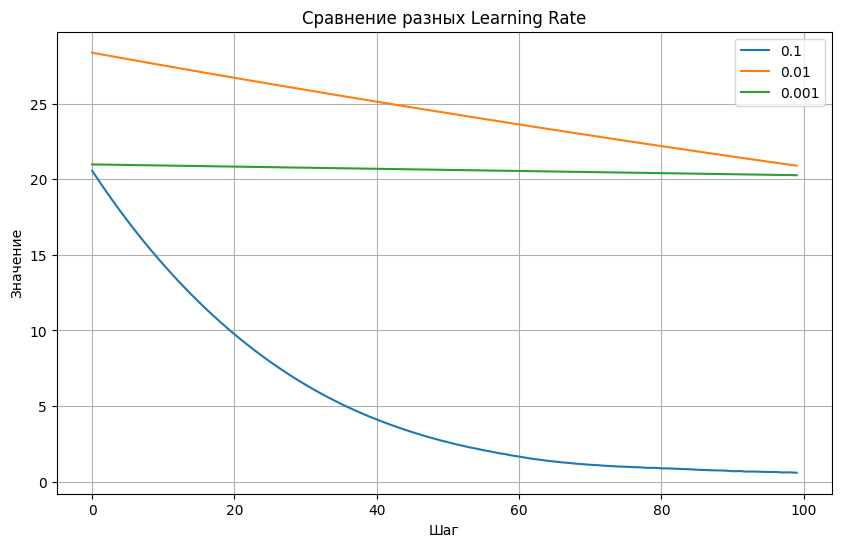

In [68]:
lrs = [1e-1, 1e-2, 1e-3]
l = {}
for lr in lrs:
    weights = torch.nn.Parameter(5 * torch.randn((10, 10)))
    opt = LION([weights], lr=lr)
    l[str(lr)] = []
    for t in range(100):
        
        opt.zero_grad() # Reset the gradients for all learnable parameters.
        loss = (weights**2).mean() # Compute a scalar loss value.
        l[str(lr)].append(loss.cpu().item())
        loss.backward() # Run backward pass, which computes gradients.
        opt.step()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Размер графика

# Проход по всем ключам и значениям в словаре
for label, values in l.items():
    plt.plot(values, label=label)  # Построение линии с подписью

# Настройка графика
plt.title("Сравнение разных Learning Rate")  # Заголовок
plt.xlabel("Шаг")              # Ось X
plt.ylabel("Значение")         # Ось Y
plt.legend()                   # Легенда (подписи линий)
plt.grid(True)                 # Сетка

# Отображение графика
plt.show()

# Learning rate scheduling

In [69]:
import math

def cosine_scheduler(t, alpha_min, alpha_max, T_w, T_c):
    if t < T_w:
        return (t / T_w) * alpha_max
    elif t >= T_w and t <= T_c:
        return alpha_min + (1/2) * (1 + math.cos((t - T_w) / (T_c - T_w) * math.pi)) * (alpha_max - alpha_min)
    else:
        return alpha_min


In [70]:
def gradient_clipping(parameters, M, eps=1e-6):
    """
    Parameters:
    - parameters: Iterable[torch.nn.Parameter] - список параметров модели
    - M: float - максимальное значение нормы
    - eps: float - малая константа для численной стабильности
    """
    grads = [p.grad for p in parameters if p.grad is not None]
    
    if not grads:
        return
    
    total_norm = torch.norm(torch.stack([torch.norm(g.detach(), 2) for g in grads]), 2)
    clip_coef = M / (total_norm + eps)
    
    if clip_coef < 1:
        for grad in grads:
            grad.mul_(clip_coef)

# Training

In [71]:
import numpy as np
import torch

def batchify(x, batch_size, context_length, device=None):
    assert len(x) >= context_length + 1, "Context length should be more than len x"
    start_indices = np.random.randint(0, len(x) - context_length, size=batch_size)
    inputs = torch.tensor([x[i: i + context_length] for i in start_indices], dtype=torch.long, device=device)
    targets = torch.tensor([x[i + 1: i + context_length + 1] for i in start_indices], dtype=torch.long, device=device)
    return (inputs, targets)


x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
batch_size = 6
context_length = 3
device = 'cpu'

a,b = batchify(x, batch_size, context_length, device)

C:\Users\okdan\AppData\Local\Temp\ipykernel_26244\2469222315.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  inputs = torch.tensor([x[i: i + context_length] for i in start_indices], dtype=torch.long, device=device)


In [72]:
import typing
import os

def save_checkpoint(model:nn.Module, optimizer:torch.optim.Optimizer, iteration:int, out:str|os.PathLike|typing.BinaryIO|typing.IO[bytes]):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'iteration': iteration
    }
    torch.save(checkpoint, out)

def load_checkpoint(src:str|os.PathLike|typing.BinaryIO|typing.IO[bytes], model:nn.Module, optimizer:torch.optim.Optimizer):
    checkpoint = torch.load(src)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['iteration']

# Generating text

In [160]:
import torch
from typing import Optional

def generate(
    model,
    tokenizer,
    prefix: str,
    temperature: float = 1.0,
    max_tokens: int = 100,
    top_p: Optional[float] = None,
    device="cpu"
) -> str:
    
    model.eval()
    model.to(device)
    input_ids = tokenizer.encode(prefix, return_tensors="pt").to(device) #(bs, seq_len)
    eos_token = tokenizer.encode('<|endoftext|>')[0]

    for n in range(max_tokens):
        last_logits = model(input_ids)
        next_token_logits = last_logits[:, -1, :]
        # temperature
        next_token_logits /= temperature
        probs = softmax(next_token_logits, dim = -1)
        # top-p
        sorted_values, sorted_indices = torch.sort(probs, descending = True)
        sorted_values = sorted_values[0]
        sorted_indices = sorted_indices[0]
        cumsum = torch.cumsum(sorted_values, dim = 0)
        max_ind = torch.searchsorted(cumsum, top_p)
        selected_indices = sorted_indices[:max_ind]
        selected_values = sorted_values[:max_ind]

        if len(selected_indices) <= 1:
            sample = torch.argmax(probs, keepdims = True, dim = -1)
        else:
            sample = selected_indices[torch.multinomial(selected_values, 1)].unsqueeze(0)
        sample = sample.to(device)

        input_ids = torch.cat((input_ids, sample), dim=-1)
        prefix += tokenizer.decode(sample.item())

        if sample.item() == eos_token:
            break

    return prefix


In [161]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("C:/models/SmolLm2_360m/")
prefix = "hello world how are you"

rope=RoPE(theta=10_000., d_k=64, max_seq_len=128)
model = TransformerLM(
    vocab_size=49152, context_length=128, 
    num_layers=12, num_heads=4, d_model=256, d_ff=10 ,
    rope=rope
)


generate(
    model=model,
    tokenizer=tokenizer,
    prefix="hello world how are you",
    temperature=1.,
    max_tokens=50,
    top_p=.9,
)

'hello world how are youAppendix softer colorless Morrison heredPhone discovery renovated Y outset toddlers profitable Height spawningeas translations plainlykon civilisation Hyderabad liningSt BaldwinBey ark Protect look invadeengingpropspyplot Takes pale Determineername sudo BUPataterials Sin Markovemptive�engthsOROR intersection pickedrosso assess'

# TransformerTrainer

In [ ]:
import torch
import torch.nn as nn

import numpy as np
from tqdm import tqdm
import time
import json
import os

import sys
sys.path.append("../")

from tests.transformer_methods.transformer import TransformerLM
from tests.transformer_methods.rope import RoPE
from tests.transformer_methods.utils_transformer import *
from tests.transformer_methods.optimizers import *

In [ ]:
class TransformerTrainer:
    def __init__(self, transformer_params, optimizer_params, training_params, rope_params, load_from):
        
        self.transformer_params = transformer_params
        self.optimizer_params = optimizer_params
        self.training_params = training_params
        self.load_from = load_from

        self.checkpoint_dir = "./checkpoints/"
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        self.train_path = os.path.join("DATA_DIR", f"{training_params['dataset']}_tokenized-train.npy")
        self.valid_path = os.path.join("DATA_DIR", f"{training_params['dataset']}_tokenized-valid.npy")

        rope = RoPE(
            **rope_params, 
            device=self.training_params['device'],
            dtype=self.training_params['dtype']
        )

        self.transformer_params['rope'] = rope

        self.model = TransformerLM(
            **self.transformer_params, 
            device=self.training_params['device'],
            dtype=self.training_params['dtype']
        )

        self.optimizer = AdamW(
            self.model.parameters(),
            **self.optimizer_params,
            device=self.training_params['device'],
            dtype=self.training_params['dtype']
        )

        if self.load_from is not None:
            load_checkpoint(self.load_from, self.model, self.optimizer)
            print(f"Load model from checkpoint {load_from} path")

        self.run_id = time.strftime("%m%d_%H%M%S")
        self.load_data()

    def load_data(self):
        self.train_data = np.load(self.train_path, mmap_mode='r', allow_pickle = True).astype(np.uint16)
        self.valid_data = np.load(self.valid_path, mmap_mode='r', allow_pickle = True).astype(np.uint16)
        print('loaded data')
        assert np.max(self.valid_data) <= np.iinfo(np.uint16).max

    def train(self):
        self.start_time = time.time()

        for i in range(self.training_params["n_iter"]):
            iter_start = time.time()

            batch, targets = batchify(
                self.train_data,
                self.transformer_params['batch_size'],
                self.training_params["seq_len"],
                self.training_params["device"],
            )

            lr = cosine_scheduler(
                i, 
                self.training_params["alpha_max"], 
                self.training_params["alpha_min"], 
                self.training_params["T_w"], 
                self.training_params["T_c"]
            )

            for param_group in self.optim.param_groups:
                param_group["lr"] = lr

            logits = self.model(batch)
            loss = cross_entropy(logits, targets)

            loss.backward()

            grad_norm = gradient_clipping(self.model.parameters(), 1.0) or 0.0

            self.optimizer.step()

            self.optimizer.zero_grad(set_to_none=True)
            self.total_tokens += self.training_params['batch_size'] * self.training_params['seq_len']

            if i % self.training_params["checkpoint_every"] == 0:
                save_path = os.path.join(self.checkpoint_dir, f"checkpoint_{i}.pt")
                save_checkpoint(self.model, self.optim, i, save_path)
            
            # compute validation loss/perplexity
            if i % self.training_params["valid_every"] == 0:
                self.validate(i)

        with open(f"results_{self.run_id}.txt", "w") as f:
            f.write(f"Total tokens: {self.total_tokens}\n")
            f.write(f"Total time: {time.time() - self.start_time}\n")

            # compute final loss/perplexity
            valid_loss = self.validate(i)
            f.write(f"Final validation loss: {valid_loss}\n")

        save_path = os.path.join(self.checkpoint_dir, f"checkpoint_final.pt")
        save_checkpoint(self.model, self.optim, i, save_path)

    
    def validate(self, step):
        with torch.no_grad():
            self.model.eval()
            valid_loss = 0.0
            
            for _ in range(self.training_params["n_valid_batches"]):
                # compute validation loss/perplexity, using same batch size and seq len as training
                batch, targets = batchify(
                    self.valid_data, 
                    self.training_params["batch_size"], 
                    self.training_params["seq_len"], 
                    self.training_params["device"]
                )
                logits = self.model(batch)
                loss = cross_entropy(logits, targets)
                valid_loss += loss.item()
            
            valid_loss /= self.training_params["n_valid_batches"]
            perplexity = np.exp(valid_loss)
            
        print(f"valid_loss {valid_loss} and perplexity {perplexity} on step {step}")
        self.model.train()

        
